# 1. 라이브러리 & 데이터 준비

In [2]:
!pip install pwlf

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pwlf

In [6]:
data = pd.read_csv('hw3_data_1.csv')
x = data['x']
y = data['y']

# 2. Piecewise Linear Regression

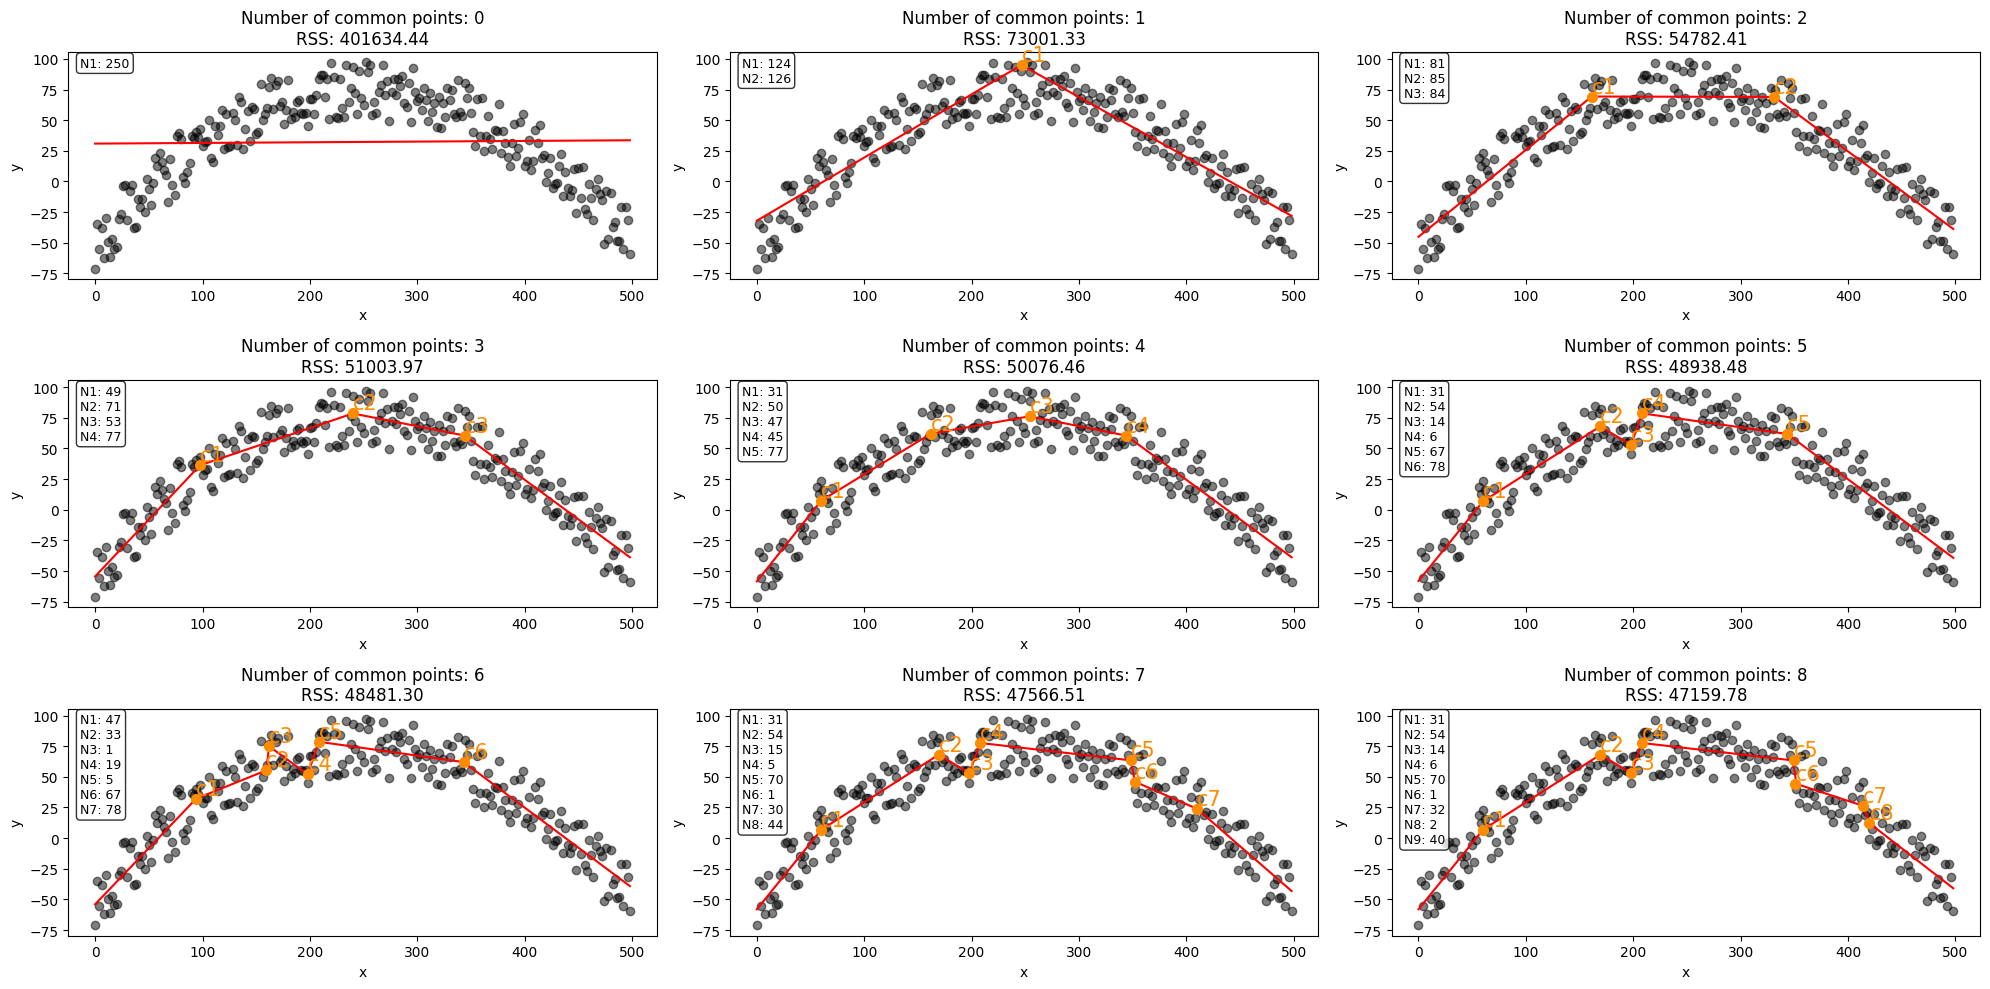

In [7]:
model = pwlf.PiecewiseLinFit(x, y)

fig, axs = plt.subplots(3, 3, figsize=(20, 10))
for ax, num_segments in zip(axs.flatten(), range(1, 10)):
    breakpoints = model.fit(num_segments)
    predictions = model.predict(x)

    residuals = y - predictions
    RSS = np.sum(residuals ** 2)

    segment_counts = np.histogram(x, bins=breakpoints)[0]

    ax.plot(x, predictions, label=f'Regression Line', color='red')
    ax.scatter(x, y, color='black', alpha=0.5, label='Original Data')

    for i, bp in enumerate(breakpoints[1:-1]):
        ax.scatter(bp, model.predict([bp]), color='darkorange', s=50, zorder=5)
        ax.text(bp, model.predict([bp]), f'c{i+1}', color='darkorange', fontsize=15, verticalalignment='bottom')

    ax.set_title(f'Number of common points: {num_segments-1}\nRSS: {RSS:.2f}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    textstr = "\n".join([f'N{i+1}: {count}' for i, count in enumerate(segment_counts)])
    ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=9, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

Common points 개수가 증가함에 따라 모델이 입력 데이터를 더 잘 표현하는 것을 확인할 수 있습니다.  
그러나 common points 개수가 5개 이상인 모델에서는 과적합의이 발생할 가능성이 있다고 생가됩니다.  
따라서 최적의 common points 개수는 4개라고 생각합니다.

# 3. Moving Least Squares Regression

### (1) Moving Least Squares 함수 정의

In [8]:
def moving_least_squares(x, y, weight_function, **kwargs):
    x_dense = np.linspace(x.min(), x.max(), 500)
    y_dense = []

    for x0 in x_dense:
        weights = weight_function(x, x0, **kwargs)

        W = np.diag(weights)
        A = np.vstack([x, np.ones(len(x))]).T
        coeffs = np.linalg.inv(A.T @ W @ A) @ (A.T @ W @ y)

        y0 = coeffs[0] * x0 + coeffs[1]
        y_dense.append(y0)

    return x_dense, np.array(y_dense)

### (2) Weighting Function 정의

In [9]:
def constant_weights(x, x0, **kwargs):
    return np.ones_like(x)

def step_weights(x, x0, radius=1.0, **kwargs):
    return np.where(np.abs(x - x0) <= radius, 1.0, 0.0)

def gaussian_weights(x, x0, sigma=1.0, **kwargs):
    return np.exp(-((x - x0) ** 2) / (2 * sigma ** 2))

### (3) 시각화

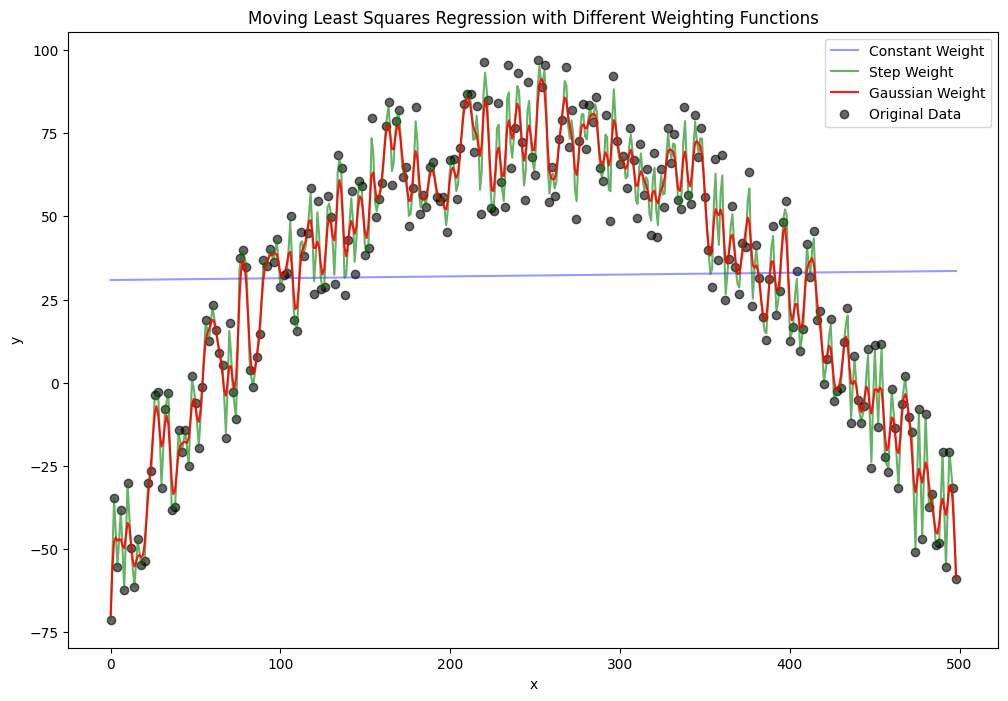

In [10]:
plt.figure(figsize=(12, 8))

weight_functions = [
    (constant_weights, {'label': 'Constant Weight', 'color': 'blue', 'alpha': 0.4}, {}),
    (step_weights,     {'label': 'Step Weight',     'color': 'green', 'alpha': 0.6}, {'radius': 2.0}),
    (gaussian_weights, {'label': 'Gaussian Weight', 'color': 'red', 'alpha': 0.9},  {'sigma': 1.5})
]

for w_func, plot_info, w_kwargs in weight_functions:
    x_dense, y_dense = moving_least_squares(x, y, w_func, **w_kwargs)
    plt.plot(x_dense, y_dense, label=plot_info['label'], color=plot_info['color'], alpha=plot_info['alpha'])

plt.scatter(x, y, color='black', alpha=0.6, label='Original Data')

plt.title('Moving Least Squares Regression with Different Weighting Functions')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

1. Constant Weight: 데이터의 변화를 잘 반영하지 못하여 단순히 평균에 가까운 수평선으로 나타납니다.  
2. Step Weight: 어느 정도 실제 데이터를 잘 반영하고 있지만, 분포 변화가 매끄럽지 않아 들쑥날쑥한 모습을 볼 수 있습니다.   
3. Gaussian Weight: 실제 데이터의 패턴을 가장 정확하고 부드럽게 나타내고 있습니다.

따라서 최적의 weighting function은 gaussian이라고 생각합니다.